# Notebook to apply networkX plots (No seeded connections)

In [1]:
import os 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

print(os.getcwd())

e:\work_projects\2024\KC5FILT\Ilicit transactions project


In [2]:
# Load data
file_name = 'output/transaction_model_output.csv'
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Pred,Prob
0,0,514.0,CASH_OUT,28659.80,C1879397053,27756.7,0.00,C356110177,341223.26,369883.06,0.0,0.0,1.0,0.62
1,1,134.0,CASH_OUT,147698.47,C970108067,313104.0,165405.53,C2122237253,2441272.92,2588971.39,0.0,0.0,0.0,0.00
2,2,187.0,CASH_OUT,236046.89,C970108067,41785.0,0.00,C1401275229,146607.42,382654.31,0.0,0.0,0.0,0.00
3,3,354.0,CASH_OUT,208695.42,C1956024073,1.0,0.00,C1401275229,4006532.76,4215228.18,0.0,0.0,0.0,0.00
4,4,180.0,CASH_OUT,188379.31,C1653796300,27259.0,0.00,C970108067,0.00,188379.31,0.0,0.0,0.0,0.00


### Create function to plot networks (filtered on fraud)

In [18]:
def plot_transaction_network(df, accOrig=[], accDest=[]):
    # Create a NetworkX graph
    G = nx.DiGraph()

    # Filter the DataFrame for transactions where nameOrig is in accOrig
    # and nameDest is in accDest
    if accOrig:
        df = df[df['nameOrig'].isin(accOrig)]  # Filter for accOrig matches
    
    if accDest:
        df = df[df['nameDest'].isin(accDest)]  # Filter for accDest matches

    # You can combine both conditions if needed
    # This includes transactions where either nameOrig or nameDest is in accOrig or accDest
    # If accOrig is provided, filter for nameOrig matches
    # If accDest is provided, filter for nameDest matches
    df = df[
        df['nameOrig'].isin(accOrig) | df['nameDest'].isin(accDest)
    ]
    print(df)

    # Aggregate to calculate frequency of transactions between pairs
    aggregated_df = (
        df.groupby(['nameOrig', 'nameDest', 'type'])
        .agg(transaction_count=('amount', 'size'), total_amount=('amount', 'sum'))
        .reset_index()
    )

    # Add edges to the graph with transaction count and total amount as attributes
    for _, row in aggregated_df.iterrows():
        if G.has_edge(row['nameOrig'], row['nameDest']):
            # If an edge already exists, update the transaction count and total amount
            G[row['nameOrig']][row['nameDest']]['transaction_count'] += row['transaction_count']
            G[row['nameOrig']][row['nameDest']]['total_amount'] += row['total_amount']
        else:
            # Otherwise, add a new edge
            G.add_edge(
                row['nameOrig'], row['nameDest'],
                transaction_count=row['transaction_count'],
                total_amount=row['total_amount'],
                type=row['type']
            )

    # Assign colors to nodes based on their transaction types
    node_colors = {}
    color_map = {'CASH_IN': '#008EAD', 'CASH_OUT': '#FFF94D', 'TRANSFER': '#00F098', 'PAYMENT': '#A80070', 'DEBIT': '#FF9E3D'}
    default_color = 'gray'  # Default color for nodes without a defined type

    # Add nodes to the graph with their type
    for node in G.nodes:
        # Find transactions originating from or going to this node
        related_transactions = aggregated_df[
            (aggregated_df['nameOrig'] == node) | (aggregated_df['nameDest'] == node)
        ]
        # Assign the most common transaction type or default color
        if not related_transactions.empty:
            common_type = related_transactions['type'].mode().iloc[0]
            node_colors[node] = color_map.get(common_type, default_color)
        else:
            node_colors[node] = default_color

    # Get color list for plotting
    node_color_list = [node_colors[node] for node in G.nodes]

    # Normalize edge widths based on transaction counts
    all_transaction_counts = [d['transaction_count'] for _, _, d in G.edges(data=True)]
    # print(all_transaction_counts)
    if len(all_transaction_counts) > 1 or len(set(all_transaction_counts)) != 1:
        min_count = min(all_transaction_counts)
        max_count = max(all_transaction_counts)
        def normalize(value, min_value, max_value, target_min=1, target_max=5):
            # check if all counts are identical
            if min_value == max_value:
                return 2  # Assign a middle value if all counts are identical
            
            return target_min + (value - min_value) * (target_max - target_min) / (max_value - min_value)

        edge_widths = [
            normalize(d['transaction_count'], min_count, max_count)
            for _, _, d in G.edges(data=True)
        ]
    else:
        edge_widths = 2

    # Plot the graph
    pos = nx.spring_layout(G, k=2, seed=2025)  # Position nodes using the spring layout
    plt.figure(figsize=(10, 5))

    # Change background color and opacity
    ax = plt.gca()
    ax.set_facecolor((0.749, 0.255, 0.486, 0))  # Set RGBA color for background
    plt.gcf().patch.set_facecolor((0.9, 0.9, 0.9, 0))  # Set RGBA color for figure background

    # Remove the borders (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Draw the nodes with colors
    nx.draw_networkx_nodes(G, pos, node_color=node_color_list, node_size=750)

    # Draw edges with normalized widths
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", width=edge_widths, style="solid", arrows=True, arrowsize=25
    )

    # Draw labels for nodes
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
    
    # Title and legend
    # title = ""
    # if filter_fraud is not None:
    #     title += f" (isFraud={filter_fraud})"
    # plt.title(title)

    # Create legends
    legend_labels = {v: k for k, v in color_map.items()}
    node_legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
        for color in color_map.values()
    ]

    # plt.legend(
    #     node_legend_handles,
    #     list(legend_labels.values()),
    #     title="Transaction Type", loc="upper left"
    # )
    
    plt.tight_layout(pad=1, w_pad=0, h_pad=0)

    plt.show()

       Unnamed: 0   step      type      amount     nameOrig  oldbalanceOrg  \
10             10   37.0  CASH_OUT    31596.45  C1527835008       31836.00   
12             12   66.0  CASH_OUT  2096634.43  C1527835008     2096634.43   
17             17   21.0  CASH_OUT   306269.64  C1527835008       30234.00   
34             39  159.0  CASH_OUT   205327.89  C1527835008       15872.00   
47             52  305.0   CASH_IN   206456.83  C1527835008       82191.00   
...           ...    ...       ...         ...          ...            ...   
27282       29259  260.0  TRANSFER  1217412.06  C1527835008       21069.00   
27287       29264  277.0  CASH_OUT   163761.73  C1527835008       21635.00   
27291       29268  160.0   CASH_IN   501543.79  C1527835008       99167.00   
27298       29275  177.0   CASH_IN   127912.08  C1527835008     5293243.19   
31486       33464  405.0  CASH_OUT   973805.75  C1527835008      973805.75   

       newbalanceOrig     nameDest  oldbalanceDest  newbalanceD

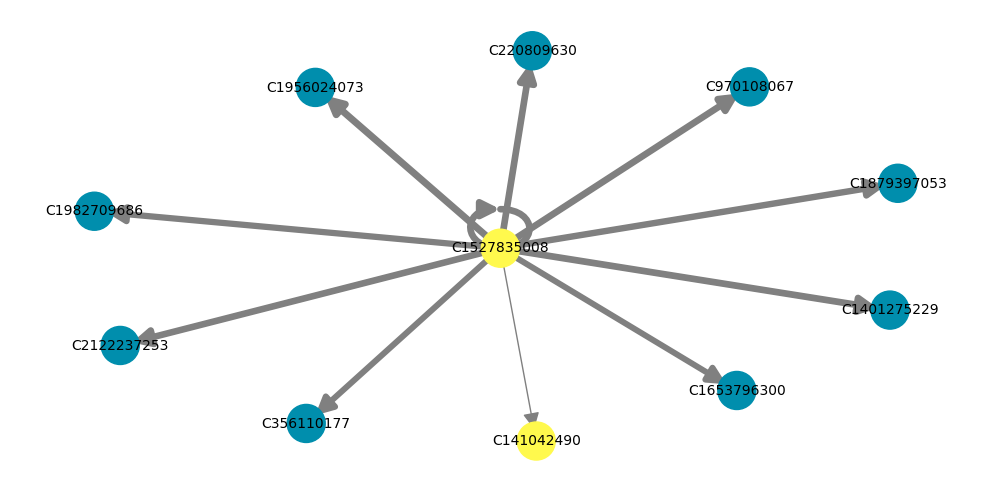

In [19]:
# Plot the network for all transactions
plot_transaction_network(df, ['C1527835008'])